In [20]:
from autoML import autoML
import pandas as pd
import sklearn as sk
import numpy as np

## Loading the data

In [21]:
data = pd.read_csv("datasets/Fish.csv")
print(data.head())
print("Data shape:", data.shape)

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
Data shape: (159, 7)


## Split into test and training set

In [22]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

train.shape, test.shape

((127, 7), (32, 7))

## Get knowledge over dataset

In [23]:
train.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
114,Perch,700.0,34.5,37.0,39.4,10.8350,6.2646
120,Perch,900.0,37.0,40.0,42.5,11.7300,7.2250
57,Whitefish,306.0,25.6,28.0,30.8,8.7780,4.6816
86,Perch,120.0,20.0,22.0,23.5,6.1100,3.4075
147,Smelt,7.0,10.1,10.6,11.6,1.7284,1.1484


The dataset has 7 attributes (incl. the target attribute *weight*). The attributes *Length1*, *Length2*, *Length3*, *Height* and *Width* are numerical. The attribute *Species* is nominal.

In [24]:
train.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,381.466929,25.885039,28.039370,30.874803,8.964154,4.335695
std,339.612191,9.790099,10.490972,11.381759,4.209266,1.627295
min,5.900000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,22.950000,6.031600,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.820400,4.305600
75%,587.500000,31.850000,35.000000,39.350000,12.379300,5.320200
max,1600.000000,56.000000,60.000000,64.000000,18.754200,7.595800


In [25]:
set(train["Species"])

{'Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'}

<AxesSubplot:ylabel='Species'>

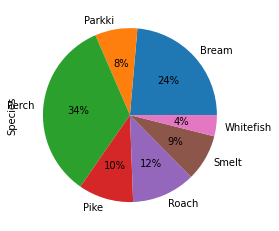

In [26]:
train.groupby("Species").size().plot.pie(ylabel="Species", autopct=lambda val: "{:0.0f}%".format(val))

<AxesSubplot:>

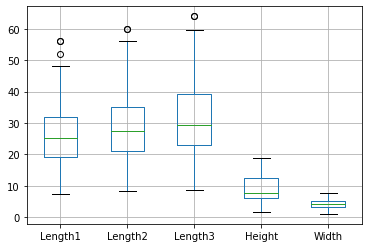

In [27]:
train.drop("Weight", axis=1).boxplot()

## Initialize all regressors

In [28]:
class DummyRegressor():
    def fit(self, X_train, y_train):
        self.range = min(y_train), max(y_train)
    
    def predict(self, X_test):
        return np.random.uniform(self.range[0], self.range[1], [len(X_test)])
    
    def get_params(self, deep=True):
        return {}      

regressors = {
    "dummy": DummyRegressor(),
    "decisionTree": sk.tree.DecisionTreeRegressor(),
    "linearRegression": sk.linear_model.LinearRegression(),
    "randomForestRegressor": sk.ensemble.RandomForestRegressor(),
    # our regressors
    "autoML": autoML(fitting_time=5, verbose=False),
}

## Check training performance

In [29]:
from sklearn.metrics import make_scorer

def relative_squared_error(y_pred, y_test):
    avg = np.average(y_test)
    error = y_pred-y_test
    mean_error = -(y_test-avg)
    return np.sum(error**2)/np.sum(mean_error**2)

def correlation_coefficient(y_pred, y_test):
    return np.corrcoef(np.array([y_pred, y_test]))[0][1]

def check_stats(predictor, X, y, name):
    
    scoring = {
        "MSE": make_scorer(sk.metrics.mean_absolute_error),
        "RSE": make_scorer(relative_squared_error),
        "CorrCoef": make_scorer(correlation_coefficient)
    }

    result = sk.model_selection.cross_validate(predictor, X, y, scoring=scoring)

    fit_time = np.mean(result["fit_time"])
    score_time = np.mean(result["score_time"])
    mse = np.mean(result["test_MSE"])
    rse = np.mean(result["test_RSE"])
    corr = np.mean(result["test_CorrCoef"])

    return name, mse, rse, corr, fit_time, score_time

In [30]:
def get_performance(regressors, X, y):
    # check stats of all regressors
    columns = ["Name", "MAE", "RSE", "Corr", "Fit time", "Score time"]
    rows = []
    for regressor_name in regressors:
        stats = check_stats(regressors[regressor_name], X, y, regressor_name)
        rows.append(stats)
    stats = pd.DataFrame(rows, columns=columns)
    return stats

### Preprocessing - Removing "Species"

In [31]:
X_rem = train.drop(["Weight", "Species"], axis=1)
y_rem = train["Weight"]

stats_rem = get_performance(regressors, X_rem, y_rem)
stats_rem

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,611.208239,2.406970,-0.062916,0.000560,0.001076
1,decisionTree,44.981538,0.043223,0.983340,0.002274,0.001718
2,linearRegression,93.501616,0.167218,0.931742,0.001835,0.002232
3,randomForestRegressor,37.488021,0.039241,0.983801,0.090613,0.007395
4,autoML,99.870154,0.504474,0.952076,5.639743,0.012328


### Preprocessing - One-hot encoding "Species"

In [32]:
train_encoded = pd.get_dummies(train, columns=["Species"])
train_encoded.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
114,700.0,34.5,37.0,39.4,10.8350,6.2646,0,0,1,0,0,0,0
120,900.0,37.0,40.0,42.5,11.7300,7.2250,0,0,1,0,0,0,0
57,306.0,25.6,28.0,30.8,8.7780,4.6816,0,0,0,0,0,0,1
86,120.0,20.0,22.0,23.5,6.1100,3.4075,0,0,1,0,0,0,0
147,7.0,10.1,10.6,11.6,1.7284,1.1484,0,0,0,0,0,1,0


In [37]:
X_enc = train_encoded.drop("Weight", axis=1)
y_enc = train_encoded["Weight"]

stats_enc = get_performance(regressors, X_enc, y_enc)
stats_enc

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,562.122481,2.486253,-0.017681,0.000662,0.000726
1,decisionTree,53.010462,0.066636,0.973430,0.001895,0.001723
2,linearRegression,77.429552,0.110479,0.953850,0.001925,0.001837
3,randomForestRegressor,39.179228,0.046668,0.981633,0.093795,0.008452
4,autoML,101.911090,0.415633,0.965319,5.557537,0.011958


### Preprocessing - One-hot encoding + standardization

In [34]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_enc)

X_std = pd.DataFrame(x_scaled, columns=X_enc.columns)
y_std = y_enc

X_std.index = y_std.index

stats_std = get_performance(regressors, X_std, y_std)
stats_std

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,544.449082,2.346401,0.084311,0.000484,0.000913
1,decisionTree,49.109077,0.049539,0.980765,0.002074,0.002432
2,linearRegression,77.429552,0.110479,0.953850,0.001602,0.001575
3,randomForestRegressor,38.327462,0.046859,0.982844,0.092293,0.007451
4,autoML,139.996387,7.181924,0.967824,5.517531,0.011094


The performance checks show that the preprocessing step of one-hot encode the "Species" column is better than removing the column and has not real benefit over additional standardization.
Therefore one-hot encoding is enough.

## Checking performance on test set

In [35]:
from time import time

def get_test_performance(regressor, X, y):   
    t = time()
    y_pred = regressor.predict(X)
    t = time() - t
    
    mae = sk.metrics.mean_absolute_error(y_pred, y)
    rse = relative_squared_error(y_pred, y)
    corr = correlation_coefficient(y_pred,y)
    
    return mae, rse, corr, t
    

In [38]:
X_test = pd.get_dummies(test.drop("Weight", axis=1), columns=["Species"])
y_test = test["Weight"]

X_train = pd.get_dummies(train.drop("Weight", axis=1), columns=["Species"])
y_train = train["Weight"]

test_performance = []
for name in regressors:
    regressor = regressors[name]
    train_t = time()
    regressor.fit(X_train, y_train)
    train_t = time() - train_t
    mae, rse, corr, test_t = get_test_performance(regressor, X_test, y_test)
    test_performance.append((name, mae, rse, corr, train_t, test_t))

test_stats = pd.DataFrame(test_performance, columns=["Name", "MAE", "RSE", "CorrCoeff", "TrainTime", "TestTime"])
test_stats

,Name,MAE,RSE,CorrCoeff,TrainTime,TestTime
0,dummy,615.122076,3.197722,0.073398,0.000040,0.000047
1,decisionTree,75.056250,0.080276,0.959341,0.001724,0.001071
2,linearRegression,70.435675,0.051550,0.978010,0.001514,0.001037
3,randomForestRegressor,50.123937,0.032268,0.985922,0.101411,0.007190
4,autoML,114.605941,0.103610,0.984868,5.268773,0.011175
